# Data Simulation 

###  Reproducing results from:
### "Bayesian Methods for Media Mix Modeling with Carryover and Shape Effects"
#### 5.1 Simulation Setting and Prior Distributions

The simulated data set contains 2 years of weekly data, sales, three media and one control variable
(price). Media variables are generated by adding white noise to a sinusoidal seasonality with one
year as a period; the control variable is generated as an ARIMA time series. For each media, the
spend is scaled to be from 0 to 1 for convenience. Table 1 contains the parameters used in the model
in (7) to generate sales as the response variable. Here we assume no transformation is used on the
response variable. Figure 4 shows the time series plots of the sales and the media spend. Due to
the data generation mechanism, weekly spend of all media have the same marginal distribution.
Figure 4d shows the histogram of weekly spend of Media 1, which is quite spread out from 0 to 1.
The media variables are also very weakly correlated with a correlation of 0.09.

#### Features

- date (day)
- media channels (x3) - white noise with sinusoidal seasonality with one year as a period
- control variable - ARIMA time series
- sales - response variable 

In [40]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa import arima_process as arima

## Carryover effect

In [236]:
def geoDecay(alpha,L):
    
    '''
    weighted average with geometric decay.
    weight_T = alpha ^ T-1 .
    Return weights of length L to calculate weighted averages with. 
    
    alpha: scalar, between [0,1], retention rate 
    L: scalar, maximum duration of carryover effect
    returns: numpy array of size (L,). 
    '''
    return alpha**(np.ones(L).cumsum()-1)[::-1]

def delayed_adstock(alpha, theta, L):
    """
    weighted average with dealyed adstock function
    weight_T = alpha ^ (T-1- theta)^2
    Return weights to calculate weighted averages with. 
    
    alpha: scalar, between [0,1], retention rate 
    L: scalar, maximum duration of carryover effect
    theta: 
    returns: numpy array, size (L,). 
    """
    return (alpha**((np.ones(L).cumsum()-1)-theta)**2)[::-1] 



In [237]:
def carryover(df, columns, alpha, theta=None, L=None, decay = 'geo', date_col = 'date'):
    
    weights = geoDecay(alpha, L) if decay == 'geo' else delayed_adstock(alpha, theta, L)
    print(weights)
    df_carryover = (df.set_index(date_col)[columns]
                    .rolling(window=L, center=False, min_periods=1)
                    .apply(lambda x: np.sum(weights[-len(x):]*x) / np.sum(weights[-len(x):]), raw=False)
                    .reset_index())
    
    columns_dict = {col:col+'_wma_{}'.format(window) for col in columns}
    df_carryover.rename(columns=columns_dict, inplace=True) 
    
    return df_carryover


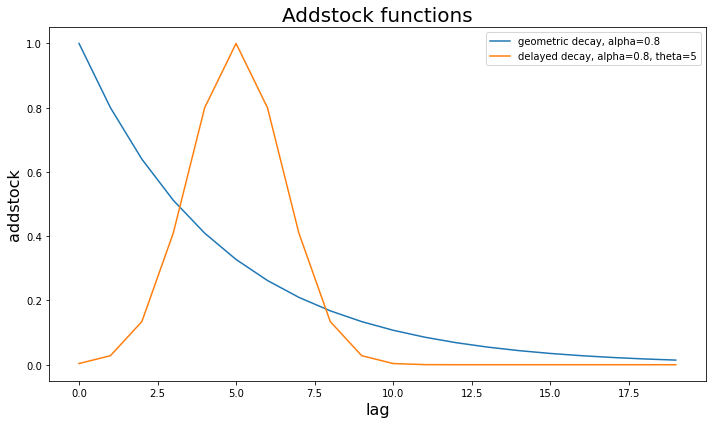

In [274]:
alpha = 0.8
theta = 5
L=20
x = np.linspace(start=0, stop=19, num=L)

plt.figure(figsize=(10,6))
plt.plot(x,geoDecay(alpha=alpha, L=L)[::-1], label = 'geometric decay, alpha={}'.format(alpha))
plt.plot(x,delayed_adstock(alpha=alpha, theta=theta, L=L)[::-1], 
         label='delayed decay, alpha={}, theta={}'.format(alpha,theta))
plt.legend()
plt.title('Addstock functions', fontsize=20)
plt.xlabel('lag',fontsize=16)
plt.ylabel('addstock', fontsize=16)
plt.tight_layout()

# Shape effect

In [275]:
def beta_hill(x, S, K, beta):
    return beta - (K**S*beta)/(x**S+K**S)

In [283]:
beta = [0.3,0.3925,0.3,0.3,0.8,1.144]
S = [1,0.748,2,0.5,2,1.867]
K = [0.5,0.95,0.5,0.5,1.5,2]
colors = ['k','k','r','g','b','b']
lines = ['-','--','-','-','-','--']
labels = ['beta={} S={} K={}'.format(b,s,k) for (b,s,k) in zip(beta,S,K)]

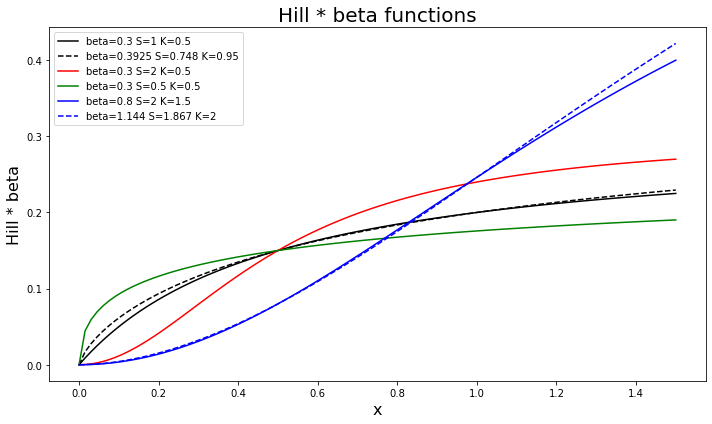

In [284]:
x = np.linspace(start=0, stop=1.5, num=100)

plt.figure(figsize=(10,6))
for i in range(len(beta)):
    b = beta[i]
    s = S[i]
    k = K[i]
    plt.plot(x, beta_hill(x, s, k, b), label=labels[i], color=colors[i], linestyle=lines[i])

plt.legend()
plt.title('Hill * beta functions', fontsize=20)
plt.xlabel('x',fontsize=16)
plt.ylabel('Hill * beta', fontsize=16)
plt.tight_layout()


## Defs (channels)

In [41]:
start = 0
end = 52 *2
duration = int(end-start)
intervals = 1
period = 52 
phase_shift = 0
vertical_shift = 0
amplitude = 1

mvn_mue = [0,0,0]
mvn_sig = 1.5
mvn_cor = 0.09

In [42]:
time = np.arange(start, end, intervals)

In [43]:
def yearly_period(x, amplitude=amplitude,vertical_shift=vertical_shift,period=period, phase_shift=phase_shift):
    return amplitude * np.sin((2*math.pi / period) * (x-phase_shift)) + vertical_shift

## media channels
### 0.09 correlation

In [44]:
media_channels = yearly_period(time, amplitude=amplitude,
                               vertical_shift=vertical_shift,period=period, phase_shift=0)

In [45]:
# create covariance matrix for media channels
cov = np.zeros((3,3)) + mvn_cor
np.fill_diagonal(cov,mvn_sig)

In [46]:
### add gaussian noise
random.seed(0)

noise_1, noise_2, noise_3 = np.random.multivariate_normal(mvn_mue, cov, int(duration/intervals)).T

scaler = MinMaxScaler()

# media channel 1
media_ch1 = media_channels + noise_1
media_ch1 = np.expand_dims(media_ch1, axis=1)
media_ch1 = scaler.fit_transform(media_ch1)

# media channel 2
media_ch2 = media_channels + noise_2
media_ch2 = np.expand_dims(media_ch2, axis=1)
media_ch2 = scaler.fit_transform(media_ch2)

# media channel 1
media_ch3 = media_channels + noise_3
media_ch3 = np.expand_dims(media_ch3, axis=1)
media_ch3 = scaler.fit_transform(media_ch3)


### Control variable - price (ARIMA)

In [47]:
np.random.seed(12345)
arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag
price = arima.arma_generate_sample(ar, ma, duration)

## Response surface

- $ y_t = \tau + \sum_{m=1}^{M}{\beta_m \cdot Hill(x_{t,m}^{*},\kappa_m,S_m)} + \sum_{c=1}^{C}{\gamma_c \cdot z_{t,c}} + \epsilon_t \\ $

- $ \beta_m \cdot Hill(x_{t,m}^{*},\kappa_m,S_m) = \beta_m - \frac{\kappa_m^{S_m}\cdot \beta_m}{x_{t,m}^{S_m} +\kappa_m^{S_m} } \\ $

- $ x_{t,m}^{*} = addstock(x_{t-L+1,m,...,x_{t,m}; w_m,L}) = \frac{\sum_{l=1}^{L-1}{w_m(l)\cdot x_{t-l,m}}}{\sum_{l=1}^{L-1}{w_m(l)}}  \\ $
 - 
$ a)\ w_m^{g}(l,\alpha_m) = \alpha_m^{l} \\ \\ b)\ w_m^{d}(l,\alpha_m,\theta_m) = \alpha_m^{(l-\theta_m)^{2}} \\ l = 0,...,L-1 ,\ 0<\alpha_m <1, \ 0<\theta_m<L-1 $

In [49]:
# Prior parameter selection:
a_ch1 = 0.6
t_ch1 = 5
k_ch1 = 0.2
s_ch1 = 1
b_ch1 = 0.8

a_ch2 = 0.8
t_ch2 = 3
k_ch2 = 0.2
s_ch2 = 2
b_ch2 = 0.6

a_ch3 = 0.8
t_ch3 = 4
k_ch3 = 0.2
s_ch3 = 2
b_ch3 =0.3

L = 13
tau = 4
gamma = -0.5
mue_eps =0
var_eps = 0.05**2

## Response curve

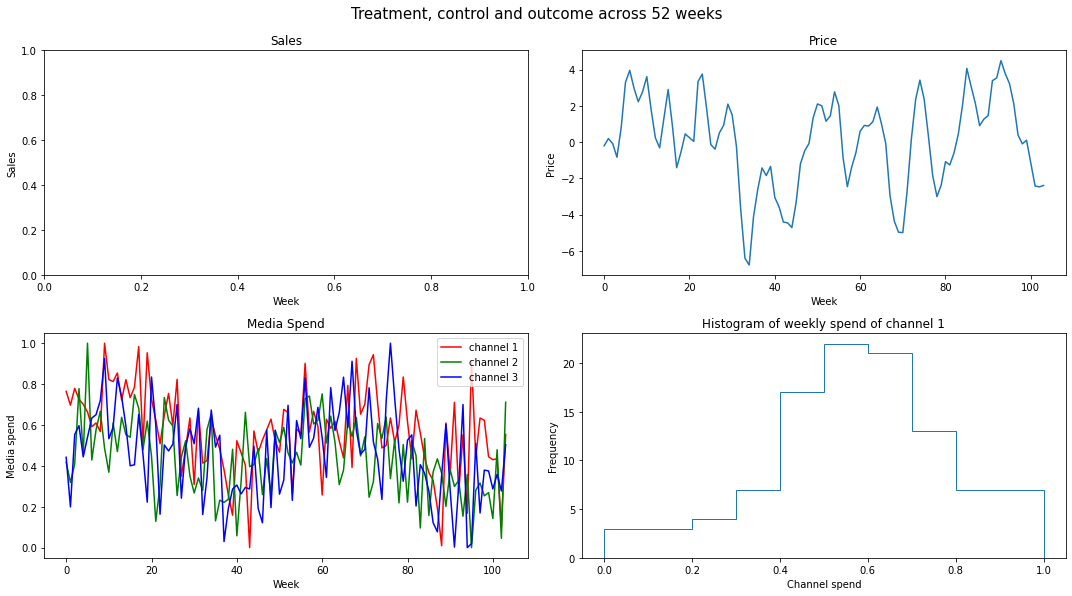

In [28]:
fig, axes = plt.subplots(2,2, figsize=(15, 8))

axes[0,0].set_xlabel('Week')
axes[0,0].set_ylabel('Sales')
axes[0,0].set_title('Sales')

axes[0,1].plot(time,price)
axes[0,1].set_xlabel('Week')
axes[0,1].set_ylabel('Price')
axes[0,1].set_title('Price')

axes[1,0].plot(time,media_ch1,color='r')
axes[1,0].plot(time,media_ch2,color='g')
axes[1,0].plot(time,media_ch3,color='b')

axes[1,0].set_xlabel('Week')
axes[1,0].set_ylabel('Media spend')
axes[1,0].legend(['channel 1','channel 2','channel 3'], loc=0)
axes[1,0].set_title('Media Spend')


axes[1,1].hist(media_ch1, bins=10, histtype='step')
axes[1,1].set_xlabel('Channel spend')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Histogram of weekly spend of channel 1')


fig.suptitle('Treatment, control and outcome across {} weeks'.format(period),fontsize=15, y=1.03 )
fig.tight_layout()

# Resident data

In [29]:
data_dir_path = 'data'
data_file_path = 'mmm_daily_nus_2020.csv'
data_path = os.path.join(data_dir_path, data_file_path)

In [30]:
data = pd.read_csv(data_path)

In [35]:
data.describe()[:3]

,YouTube,Facebook,aov,generic_queries,brand_visits,is_holiday,gross_sales,SEM,Prog,Post View
count,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,3.050000e+02,305.000000,305.000000,305.000000
mean,22730.759277,54403.318914,924.743679,37.171193,22632.901639,0.022951,1.255344e+06,153988.660992,10850.118448,4458.251491
std,11758.634405,22117.497239,57.114205,6.375521,6645.673428,0.149993,7.063695e+05,70955.416172,3335.801260,7078.953506


In [39]:
feat_desc = {feat:0 for feat in data.columns}

In [ ]:
feat_desc

- date ( days)
- demand_google searches (generic_queries)
- is_holiday - days that are defined as holiday (but before can also be a rise)
- day_of_week
- is_weekend
- is_holiday
- offer_type (not available yet)
- social_spend 
- sem_spend
- other_spend
- brand_traffic (brand_visits people searched for Resident organic, searched nectar clicked on the ad, or direct)
- gross_sales


- sem +affilates (search)
- facebook + other paid social (pinterest a little twitter)
- Ls direct (mail)
- YT (can also be post view) postview platform that are not reallty clickable.
